## Definition of a problem statement and short outline of the implementation

The present dataset contains information regarding customer support on Twitter.

The main goal with this data is twofold. First, we want to analyse networks between the companies (in form of customer support agents) and the consumers (or individuals). We are trying to find out which companies interact the most with consumers and for how long they usually interact with them (in form of a conversation on Twitter). The second thing we want to achieve is to utilize natural language processing to predict whether or nor a particular tweet was written by a company representative or by a consumer. We do so by testing multiple supervised Machine Learning classifiers and compare their respective score across different text representations.
Moreover, after carrying out Network Analysis and Natural Language Processing tasks, we applied Unsupervised Machine Learning methods to find potential underlying patterns within the data without having any specific target feature in mind, hoping to gain further insight into our dataset.
Having performed all these steps, we'll set out to finally conclude our analysis by applying the above mentioned tasks of Supervised Machine Learning.

## Description of data acquisition

The present data is part of a larger dataset that was obtained [from Kaggle](https://www.kaggle.com/thoughtvector/customer-support-on-twitter).

Initially, we tried to use the whole dataset, but given that in entails more than 3 million observations and is larger than 500MB, we decided to use a reduced version of the original dataset. In fact, we reduced the dataset to slightly more than 50.000 observations.

The Customer Support on Twitter dataset offers a large corpus of mostly English conversations between consumers and customer support agents on Twitter.

Each observation is representing a tweet by a twitter user that is either a consumer or a company representative. The variables in this dataset contain information on who wrote the tweet (author_id), when the tweet was created (created_at), whether or not it was inbound (inbound), the actual text of the tweet (text), as well as which tweet_id answered to the tweet under observation (response_tweet_id) and lastly, which tweet_id the observation tweet is a response to (in_response_to_tweet_id).


In [1]:
# import standard packages
import pandas as pd
import numpy as np

In [2]:
twitter = pd.read_csv('https://raw.githubusercontent.com/LukasBlmr/CustomerSupportTwitter/main/data.csv')

In [3]:
twitter.head()

,Unnamed: 0,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


## Data Preparation (general)

Before starting to specifically prepare our data for network analysis or natural language processing, we have to start with preparing the data in a more general way.

Our first step in doing so will be to drop the first column of the dataframe that is equal to the default Python indexing. Next, we check the dataset for missing values.

In [4]:
# drop redundant column
twitter = twitter.drop('Unnamed: 0', 1)

In [5]:
# check for NaN values
twitter.isnull().sum()

tweet_id                       2
author_id                      4
inbound                        7
created_at                     7
text                           7
response_tweet_id          16570
in_response_to_tweet_id    12926
dtype: int64

We can see that there are some missing values in the first five variables and many more in the last two. For the last two variables we accept the presence of NaN values, as this value has a meaning to itself and we will later use it to analyse the data. Regarding the other features, we will drop the observations with missing values.

In [6]:
# drop all observations where inbound has no value
twitter = twitter[twitter['inbound'].notna()]

In [7]:
# check again for NaN values
twitter.isnull().sum()

tweet_id                       0
author_id                      0
inbound                        0
created_at                     0
text                           0
response_tweet_id          16563
in_response_to_tweet_id    12919
dtype: int64

After filtering out all observations where the variable *inbound* has a missing value (NaN), we can see that all other observations with missing values in columns other than the last two, also disappeared. In the next step, we'll convert the boolean variable *inbound* to a dummy variable, changing the indication True/False to 1/0.

In [8]:
# dummy creation
twitter['inbound'] = twitter['inbound'].astype(int)

In [9]:
# check results
twitter.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,0,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,1,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,1,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,0,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,1,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


Looking at the dataset at hand, we can furthermore see that the author of a tweet can either be a company or a private person. As we want to later use NLP for predicting whether or not a tweet is from a company, we will now create another dummy variable indicating which group the tweet belongs to (either 1 for company or 0 for an individual).

In [10]:
# create variable indicating whether or not tweet author is a company
twitter['company_author'] = np.where(twitter['author_id'].str.isnumeric()==False, 1, twitter['author_id'])
a = np.array(twitter['company_author'].values.tolist())
twitter['company_author'] = np.where(a == 1, 0, a).tolist()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


In [11]:
twitter['company_author'] = twitter['company_author'].map({'1':True ,'2': False}) 
# assign respective value to observation
twitter['company_author'] = np.where(twitter['company_author'].isnull(), 0, 1) 

In [12]:
# inspect results
twitter.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,company_author
0,1,sprintcare,0,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,1
1,2,115712,1,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,0
2,3,115712,1,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,0
3,4,sprintcare,0,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,1
4,5,115712,1,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,0


Now that we also have created a column indicating whether or not a tweet is from a company or a private person we can continue with preparing our data for subsequent network analysis and natural language processing.

## Network Data - Preparation

In this part, we will create and prepare network data out of our existing dataframe for the subsequent network analysis. Our goal is to create an edgelist out of the data, which indicates which Twitter user got a response from the other Twitter users in the dataset. 

Our first step in this process will be to create another instance of the _twitter_ dataframe and adjusting this newly created dF for network analyis.

In [13]:
#import networkx
import networkx as nx

In [14]:
# check column dtypes
twitter.dtypes

tweet_id                    object
author_id                   object
inbound                      int64
created_at                  object
text                        object
response_tweet_id           object
in_response_to_tweet_id    float64
company_author               int64
dtype: object

In [15]:
# set pandas option to not show decimals for easier computation
pd.set_option('precision', 0)

In [16]:
# create new dF for response edges
response_edges = twitter

In [17]:
# inspect new dF
response_edges.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,company_author
0,1,sprintcare,0,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3,1
1,2,115712,1,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1,0
2,3,115712,1,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4,0
3,4,sprintcare,0,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5,1
4,5,115712,1,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6,0


As we want to create an edgelist out of the existing dataframe, we will now begin with dropping columns that are not relevant for our edge connections.

In [18]:
# drop all unnecessary columns
response_edges = response_edges.drop('text', 1)
response_edges = response_edges.drop('inbound', 1)
response_edges = response_edges.drop('created_at', 1)
response_edges = response_edges.drop('in_response_to_tweet_id', 1)

In [19]:
# check results
response_edges.head()

,tweet_id,author_id,response_tweet_id,company_author
0,1,sprintcare,2,1
1,2,115712,NaN,0
2,3,115712,1,0
3,4,sprintcare,3,1
4,5,115712,4,0


Altough we now have removed the columns thar are not relevant for our edgelist, we still are missing the *responder_id*, which is a column that should indicate who wrote the response tweet. We achieve this column by first creating a dictionary which allocates each *tweet_id* the respective author. Afterwards, we use this dictionary to map the *response_tweet_id* column and store the results in a new column called *responder_id*.

In [20]:
# create a dictionary for author id and tweet id
dictionary = pd.Series(response_edges.author_id.values,index=response_edges.tweet_id).to_dict()

In [ ]:
# see which tweet id belong sto which author
dictionary

#to see dictionary run functional notebook on Github

In [22]:
# create new column based on mapped column
response_edges['responder_id'] = response_edges['response_tweet_id'].map(dictionary)

In [23]:
# check results
response_edges.head()

,tweet_id,author_id,response_tweet_id,company_author,responder_id
0,1,sprintcare,2,1,115712
1,2,115712,NaN,0,NaN
2,3,115712,1,0,sprintcare
3,4,sprintcare,3,1,115712
4,5,115712,4,0,sprintcare


In [24]:
# create edge column indicating whether or not an edge is present
response_edges['received_response_edge'] = np.where(response_edges['responder_id'].isnull(), 0, 1) 

Now that we have all necessary information the edgelist needs to contain (that is a source, target and whether or not there is an edge between them), we can drop the columns we no longer need from our edgelist.

In [25]:
# drop columns that are not needed for edgelist
response_edges = response_edges.drop('tweet_id', 1)
response_edges = response_edges.drop('response_tweet_id', 1)

In [26]:
# final edge list for receiving response network
response_edges.head(10)

,author_id,company_author,responder_id,received_response_edge
0,sprintcare,1,115712,1
1,115712,0,NaN,0
2,115712,0,sprintcare,1
3,sprintcare,1,115712,1
4,115712,0,sprintcare,1
5,sprintcare,1,NaN,0
6,115712,0,NaN,0
7,sprintcare,1,NaN,0
8,115713,0,NaN,0
9,sprintcare,1,115713,1



As we are only interested in keeping the values where there is an edge present, we will drop all observations where the last column has a value of zero. This zero indicates that the **particular** tweet (the observation) was not responded to (yet). Hence, we are only keeping tweets that received a response. 

In [27]:
# remove all non-existent edges
response_edges = response_edges[response_edges.received_response_edge != 0]

Now let's have a look at how many unique author's IDs are there.

In [28]:
#print author_id lenght
len(response_edges.author_id.unique())

12027

As we later want to use each *author_id* as a node, 12027 seems to be a bit much for the network. As such, we're limiting the authors by grouping all consumers into one group that we name **Individual**. Furthermore, we want to exclude all tweets where *author_id* and *responder_id* are the same value.

In [29]:
# group all individuals together
response_edges['author_id'] = response_edges['author_id'].str.replace('\d+', 'Individual')
response_edges['responder_id'] = response_edges['responder_id'].str.replace('\d+', 'Individual')

In [30]:
# exclude all rows where author is equal to responder
response_edges = response_edges[response_edges['author_id'] != response_edges['responder_id']]

In [31]:
# check new length of edgelist
len(response_edges.author_id.unique())

96

Now that we have grouped all consumers into one group, we can create a graph object out of our edge list. We do so using the *nx.from_pandas_edgelist* function. We will also check for isolated nodes.

In [32]:
# turn edgelist into graph object
g_response = nx.from_pandas_edgelist(response_edges, source='author_id', target='responder_id', edge_attr='received_response_edge', create_using = nx.DiGraph)

In [33]:
# check for isolated nodes
list(nx.isolates(g_response))

[]

In [34]:
# inspect graph object
print(nx.info(g_response))

Name: 
Type: DiGraph
Number of nodes: 102
Number of edges: 197
Average in degree:   1.9314
Average out degree:   1.9314


After we have created the graph object of the response network, we want to attach some attributes to the nodes, such as the different centralities and whether or not the node is a company or a consumer. We do so by first creating another instance of the *response_edges* dataframe that we call *attributes*. This newly created dataframe is then processed to only contain relevant node attributes.

In [35]:
# create attributes dataframe
attributes = response_edges

In [36]:
# inspect dataframe
attributes.head()

,author_id,company_author,responder_id,received_response_edge
0,sprintcare,1,Individual,1
2,Individual,0,sprintcare,1
3,sprintcare,1,Individual,1
4,Individual,0,sprintcare,1
9,sprintcare,1,Individual,1


Looking at the dataframe above reveals that we need to drop the columns that are not displaying a attribute of the nodes, which in our case represent twitter user id's. We will hence drop the columns *responder_id* and *received_response_edge*, as both contain information that is not relevant for our node attributes. We furthermore set the index of our *attributes* dataframe to the author id.

In [37]:
# drop columns that are no longer needed
attributes = attributes.drop('responder_id', 1)
attributes = attributes.drop('received_response_edge', 1)

In [38]:
# set index to be id
attributes.set_index('author_id',inplace=True)

Now we will transform our *attributes* dataframe to a dictionary, so that we can later add it to our node attributes. After doing so, we will calculate the different centralities for our network and add them as node attributes, together with the previously created dictionary.

In [39]:
# transform dataframe to dictionary
attributes_dict=attributes.T.to_dict()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  


In [40]:
# Calculate centralities for the response network
centrality_dgr_response = nx.degree_centrality(g_response)
centrality_eigen_response = nx.eigenvector_centrality_numpy(g_response)
centrality_between_response = nx.betweenness_centrality(g_response)

# set node attributes
nx.set_node_attributes(g_response, centrality_dgr_response, 'centrality_dgr')
nx.set_node_attributes(g_response, centrality_eigen_response, 'centrality_eigen')
nx.set_node_attributes(g_response, centrality_between_response, 'centrality_between')

In [41]:
# set node attributes for the response network
nx.set_node_attributes(g_response, attributes_dict)

In [ ]:
# quick inspection of the graph object nodes
g_response.nodes(data=True)

#to see g_response.nodes run functional notebook on Github

In the final network data preparation step, we will create a dataframe from our graph object that displays information on the different attributes of each node.

In [43]:
# create dataframe from advice network
nodes_response = pd.DataFrame.from_dict(dict(g_response.nodes(data=True)),orient='index')
nodes_response.head()

,centrality_dgr,centrality_eigen,centrality_between,company_author
sprintcare,2e-02,7e-02,0e+00,1
Individual,2e+00,7e-01,9e-01,0
Ask_Spectrum,2e-02,7e-02,0e+00,1
VerizonSupport,2e-02,7e-02,0e+00,1
ChipotleTweets,2e-02,7e-02,0e+00,1


## Network Analysis

After having created a graph object and adding the node attributes, we can analyse some network level and node level characteristics and indicators. The first metrics are the top network performers and then we calculate density, transitivity and reciprocity of the network.

### Top Network Authors and Responders

Now that we have the final data for the edges, we want to explore some of its characteristics. First, we want to get an overview of the top 10 responders and authors by employing the *Counter* function.

In [44]:
# import Counter
from collections import Counter

# count responder id's and show top 10
counts = Counter(response_edges['responder_id'])
counts.most_common(10)

[('Individual', 8379),
 ('AmazonHelp', 2257),
 ('AppleSupport', 1520),
 ('Uber_Support', 851),
 ('ChipotleTweets', 654),
 ('SpotifyCares', 557),
 ('TMobileHelp', 419),
 ('SouthwestAir', 413),
 ('hulu_support', 407),
 ('comcastcares', 396)]

In [45]:
# count author id's and show top 10
counts = Counter(response_edges['author_id'])
counts.most_common(10)

[('Individual', 17440),
 ('AmazonHelp', 1399),
 ('AppleSupport', 562),
 ('Uber_Support', 269),
 ('sainsburys', 246),
 ('SpotifyCares', 239),
 ('British_Airways', 225),
 ('OIndividual', 220),
 ('VerizonSupport', 215),
 ('Tesco', 212)]

We can see that some of the companies in the two lists are identical. As the dataset contains information on each tweet, meaning it also captures longer conversations, this definitely makes sense.

### Network Level Characteristics

We first calculate density, transitivity and reciprocity measures. Then, we show a simple visualization of the network.

In [46]:
# Density for response network
density = nx.density(g_response)
print("Network density:", density)

Network density: 0.019122500485342652


In [47]:
# Transitivity for response network
transitivity = nx.transitivity(g_response)
print("Transitivity:", transitivity)

Transitivity: 0.0002969708968521085


In [48]:
# Reciprocity for response network
reciprocity = nx.reciprocity(g_response)
print("Reciprocity:", reciprocity)

Reciprocity: 0.9644670050761421


Looking at the above network level indicators reveals some interesting insights. The network appears not to be very dense while also having very little transitivity. Both numbers make sense when we consider that we are dealing with customer support data from Twitter, where a tweet is usually a conversation from a consumer to the company. Consequently, the high reciprocity score also makes sense, as tweets to the customer support of a company are like queries, which normally are answered to - meaning that the conversation is reciprocal.

Below, we've calculate the assortativity coefficient for the *company_author* attribute.

In [49]:
# calculate assortativity coefficient for company_author attribute
r_company = nx.attribute_assortativity_coefficient(g_response, 'company_author')
r_company

-0.9307930793079306

The result for the assortativity coefficient is also what we expected. Essentially, this number indicates whether or not Twitter users are more likely get a response when they share the same value for the company author column. In the present case, the number of almost -0.94 suggests the opposite. As the present case depicts tweets from consumers to company representatives, this value makes sense as it would be untypical for two companies to respond to each other in our dataset.

Below we provide a visualization of the response network.

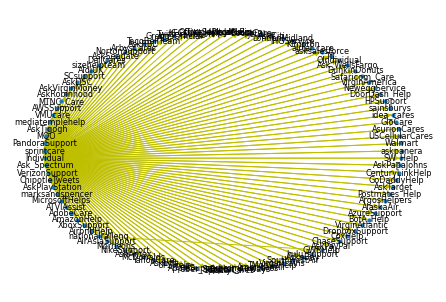

In [50]:
pos = nx.shell_layout(g_response, scale=5)  # double distance between all nodes
nx.draw(g_response, pos, node_size=10, edge_color='y', font_size=8, font_color='k', with_labels=True)

We can nicely see that there is one node where almost all other nodes are connected to. This node is the *Individual* node, which is the grouped node containing all consumers. The edges typically go from the consumer to all types of different companies, with one exception being the edge towards the bottom of the visualization.

To make this more clear, a similar visualizations showing where the edges are concentrated at is provided below.

In [51]:
from matplotlib import pyplot as plt

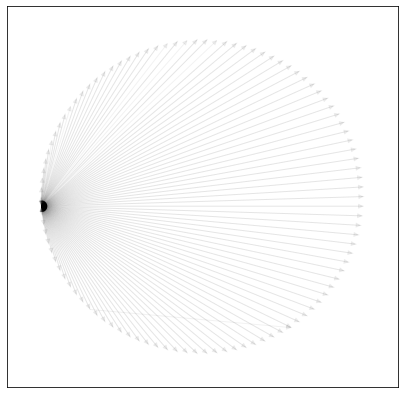

In [52]:
pos = nx.shell_layout(g_response, scale=5)  # double distance between all nodes
plt.rcParams.update({'figure.figsize': (7, 7)})
nx.draw_networkx(
        g_response, 
        pos=pos, 
        node_size=0, 
        edge_color="k", 
        alpha=0.05, 
        with_labels=False)

In [53]:
# import necessary packages for community detection
from networkx.algorithms import community
import networkx.algorithms.community as nxcom

In [54]:
# Find the communities
communities = sorted(nxcom._naive_greedy_modularity_communities(g_response))
# Count the communities
print(f"The response network has {len(communities)} communities.")

The response network has 2 communities.


Coherently with how we set up our network, we have indeed found two communities: the individuals and the company representatives.

## NLP - Preparation
In the following section, in order to proceed with Natural Language Processing and the analysis it entails, the original dataframe will be firstly subset into a new one, *twitter_nlp*. Then the tweets' text will be cleaned out of mentions, emojis as well as other elements that don't particularly add to the meaning of the text. It will be lowered, cleaned out of potential word-contraction as well as stopwords (commonly used words that don't add any specific meaning to the text). Finally, tokens will be extracted out of the clean text of the tweets and the _tokens_ column of _twitter_nlp_ will be attachted to the original dataframe, for ease of later use in UML and SML.

In [55]:
twitter.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,company_author
0,1,sprintcare,0,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3,1
1,2,115712,1,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1,0
2,3,115712,1,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4,0
3,4,sprintcare,0,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5,1
4,5,115712,1,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6,0


In [56]:
#subset the df for NLP
twitter_nlp = twitter.filter(['text'], axis =1) 
twitter_nlp.head()

,text
0,@115712 I understand. I would like to assist y...
1,@sprintcare and how do you propose we do that
2,@sprintcare I have sent several private messag...
3,@115712 Please send us a Private Message so th...
4,@sprintcare I did.


To make the cleaning and parsing action on tweets easier, we'll load Preprocessor, a preprocessing library for Twitter data in Python: with only a line of code, the tweets will be clearned out of emojis, mentions, urls leaving us with "pure" text.

In [57]:
#install the preprocessor
!pip install tweet-preprocessor -qq
import preprocessor as p

In [58]:
#set options for text cleaning
p.set_options(p.OPT.RESERVED, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.SMILEY, p.OPT.URL, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.NUMBER)

In [59]:
#in order to apply p.clean, replace NaN values with a space
twitter_nlp['text'] = twitter_nlp['text'].fillna(' ').apply(str)

In [60]:
#clean text
twitter_nlp['text_clean'] = twitter_nlp['text'].map(p.clean)
twitter_nlp.head()

,text,text_clean
0,@115712 I understand. I would like to assist y...,I understand. I would like to assist you. We w...
1,@sprintcare and how do you propose we do that,and how do you propose we do that
2,@sprintcare I have sent several private messag...,I have sent several private messages and no on...
3,@115712 Please send us a Private Message so th...,Please send us a Private Message so that we ca...
4,@sprintcare I did.,I did.


Now that we have cleaned the text, we want to further optimize it for the later part of the analysis. Hence, we will here make all text lowercase and decontract common contractions used when tweeting. Afterwards, stopwords are imported and the function to remove them, applied.

In [61]:
#lowercase tweets
twitter_nlp['text_clean'] = twitter_nlp['text_clean'].str.lower()

In [62]:
#import regular expression operations
import re

In [63]:
# define decontraction function
def decontract(phrase):
    # specific contractions
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"dat","that", phrase)
    phrase = re.sub(r"dats","that is", phrase)

    # general contractions
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [64]:
# apply function to cleaned tweets
twitter_nlp['text_clean'] = twitter_nlp['text_clean'].map(decontract)

In [65]:
#load stop words
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:
#add extra stopwords
stop_words = stopwords.words('english')[:]
stop_words.extend(["rt", "us"])

In [67]:
#check stop_words
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Tokenization

Below, we apply the *TweetTokenizer* to extract tokens from the cleaned and pre-processed text.

In [68]:
#load TweetTokenizer
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

In [69]:
#remove stopwords and tokenize
twitter_nlp['tokens'] = twitter_nlp['text_clean'].map(lambda row: [tok.lower() for tok in tknzr.tokenize(row) if tok not in stop_words and tok.isalpha()])
twitter_nlp.head()

,text,text_clean,tokens
0,@115712 I understand. I would like to assist y...,i understand. i would like to assist you. we w...,"[understand, would, like, assist, would, need,..."
1,@sprintcare and how do you propose we do that,and how do you propose we do that,[propose]
2,@sprintcare I have sent several private messag...,i have sent several private messages and no on...,"[sent, several, private, messages, one, respon..."
3,@115712 Please send us a Private Message so th...,please send us a private message so that we ca...,"[please, send, private, message, assist, click..."
4,@sprintcare I did.,i did.,[]


Above we can see that a new colum containing the text tokens has been created. To proceed, we'll make use of Gensim, an open-source library for natural language processing and later on, for unsupervised topic modeling.

In [70]:
#import gensim
import gensim

At this point of the preprocessing NLP pipeline one could further clean the text by lemmatizing or stemming the tokens, as shown below. However, because of the later influence it had on the ML models, we decided not to use the tokens generated out of *text_stem* but rather the previously created ones out of the *text_clean* column.

In [71]:
#stemmer
from gensim.parsing.porter import PorterStemmer
stem = PorterStemmer() 

twitter_nlp['text_stem'] = stem.stem_documents(twitter_nlp['text_clean']) 
twitter_nlp.head()

,text,text_clean,tokens,text_stem
0,@115712 I understand. I would like to assist y...,i understand. i would like to assist you. we w...,"[understand, would, like, assist, would, need,...",i understand. i would like to assist you. we w...
1,@sprintcare and how do you propose we do that,and how do you propose we do that,[propose],and how do you propos we do that
2,@sprintcare I have sent several private messag...,i have sent several private messages and no on...,"[sent, several, private, messages, one, respon...",i have sent sever privat messag and no on is r...
3,@115712 Please send us a Private Message so th...,please send us a private message so that we ca...,"[please, send, private, message, assist, click...",pleas send us a privat messag so that we can f...
4,@sprintcare I did.,i did.,[],i did.


In [72]:
#add the tokens column to the original df for future ML purposes
twitter['tokens'] = twitter_nlp['tokens']
twitter.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,company_author,tokens
0,1,sprintcare,0,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3,1,"[understand, would, like, assist, would, need,..."
1,2,115712,1,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1,0,[propose]
2,3,115712,1,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4,0,"[sent, several, private, messages, one, respon..."
3,4,sprintcare,0,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5,1,"[please, send, private, message, assist, click..."
4,5,115712,1,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6,0,[]


## Text Exploration
Before starting with more thorough natural language analysis, we'll take a quick look at what type of text we are dealing with, firstly by constructing a word cloud, a nice graphic that will immediately comunicate the text's tone and later, through simple word counts.

###Word Cloud

One nice way of exploring and also showcasing our text are word clouds. We achieve this word cloud by first converting all tokens to a list of strings, which we then apply the WordCloud function to that we will import from *wordcloud*.

In [73]:
#convert token list into a list of strings
twitter_nlp['tokens_str'] = [' '.join(map(str, l)) for l in twitter_nlp['tokens']]
twitter_nlp.head()

,text,text_clean,tokens,text_stem,tokens_str
0,@115712 I understand. I would like to assist y...,i understand. i would like to assist you. we w...,"[understand, would, like, assist, would, need,...",i understand. i would like to assist you. we w...,understand would like assist would need get pr...
1,@sprintcare and how do you propose we do that,and how do you propose we do that,[propose],and how do you propos we do that,propose
2,@sprintcare I have sent several private messag...,i have sent several private messages and no on...,"[sent, several, private, messages, one, respon...",i have sent sever privat messag and no on is r...,sent several private messages one responding u...
3,@115712 Please send us a Private Message so th...,please send us a private message so that we ca...,"[please, send, private, message, assist, click...",pleas send us a privat messag so that we can f...,please send private message assist click messa...
4,@sprintcare I did.,i did.,[],i did.,


In [74]:
#import the wordcloud library
from wordcloud import WordCloud

In [75]:
#join tokens_str together
long_string = ','.join(list(twitter_nlp['tokens_str'].values))

In [76]:
#create the object wordcloud
wordcloud = WordCloud(background_color= "white", max_words=5000, contour_width=3, contour_color='steelblue')

In [77]:
#generate the customer tweets word cloud
wordcloud.generate(long_string)

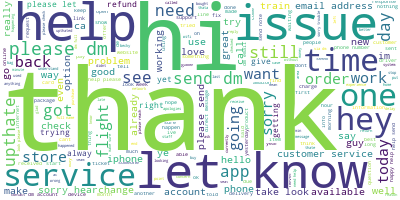

In [78]:
#visualize it
wordcloud.to_image()

The graphic immediately draws attention on what customer service is all about: being polite and friendly in providing support and help customers as they are dealing with potential issues. All of the words protrayed can be linked to this particular statement.

### Word Count
Through the Counter fuction the most frequent words will be calculated and displayed. After that, we'll calculate also the average length of each tweet, seeking to get a feel of what kind of responses users are usually dealing with.

In [79]:
#import necessary tools
import itertools
from collections import Counter

In [80]:
#turn twitter_nlp.tokens into a consecutive, iterable sequence
chain_twitter_nlp = list(itertools.chain(*twitter_nlp['tokens']))

In [81]:
#apply the counter function to the sequence
counts_twitter_nlp = Counter(chain_twitter_nlp)

In [82]:
#create a term frequency df 
tokens_twitter_nlp = pd.DataFrame(counts_twitter_nlp.most_common(15), columns=['words', 'count'])
tokens_twitter_nlp.head(15)

,words,count
0,please,6607
1,dm,5113
2,help,4425
3,hi,3791
4,thanks,3631
5,get,3355
6,would,3110
7,sorry,3040
8,know,2458
9,let,2309


The word count confirms what was deducted at a first glance: "please" leads the chart by far, immediately followed by "dm" (often when customers/others tweet seeking customer care, the message is politely redirected to a more private setting, both for a better service and for privacy reason on both sides). The chart above confirms that vocabolary used in this tweets doesn't contain any hidden surprise or unsuspected elements, but instead is perfectly aligned with the typical tone of customer care, polite and service-driven.

In [83]:
from statistics import mean, median
tweets_lengths = [len(tweet) for tweet in twitter_nlp["text_clean"]]
print("The average amount of words in tweets are %s" % mean(tweets_lengths))

The average amount of words in tweets are 86.57428


As far as word count in terms of lengths of the tweets, the dataset contain fairly brief texts, only around 87 charachters long (out of the 280 max lenght allowed by Twitter).

After having taken this quick glance, in the next section, NLP will be applied to get a further insight in the tweets, through text vectorization (BoW and TFDIDF), dimensionality reducion (LSI) and through topic modelling (LDA), where these topics/clusters will be further explored later on in UML.

## Natural Language Processing (NLP)
Through NLP text or in Python terms, string features can be converted into numerical features and thus, analyzed. We'll therefore proceed by vectorizing these tweets through both a Bag of Words and Tf-Idf text representation and later on apply some dimensionality reduction models such as LSI and LDA to gain further insight into the nature of the tweets.

###Bag of Words (BoW)
A bag-of-words is a representation of text that describes the occurrence of words within a document; this word count, basically converts text into vector. First the dataset will be separated into test and train sets to be later used for ML purpouses. Through Gensim, a dictionary of all the words at hand will be constructed, against which the BoW will be created matching each term in the vocabulary with the frequence it appears in the tweet being analyzed.



In [84]:
#train/test model
from sklearn.model_selection import train_test_split

# import packages for feature matrix transformation
from gensim.matutils import corpus2csc, corpus2dense

#Gensim Dictionary
from gensim.corpora.dictionary import Dictionary

In [85]:
# define train and test set for tweets dataframe
train_tweets, test_tweets = train_test_split(twitter, test_size=0.25, shuffle=True, stratify=twitter['company_author'], random_state=10)

In [86]:
# build a machine learning dictionary for train and test tweets
dictionary_ml = Dictionary(train_tweets['tokens'])

# filter for extreme values
dictionary_ml.filter_extremes(no_below = 25, no_above=0.4)

In [87]:
# construct corpora using the machine learning dictionary
train_ml_corpus = [dictionary_ml.doc2bow(doc) for doc in train_tweets['tokens']]
test_ml_corpus = [dictionary_ml.doc2bow(doc) for doc in test_tweets['tokens']]

In [88]:
train_tweets.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,company_author,tokens
36999,46882,126434,1,Sun Nov 19 04:08:59 +0000 2017,@115900 when i call your shit provider i expec...,"46881,46883",NaN,0,"[call, shit, provider, expect, talk, someone, ..."
40952,51548,CenturyLinkHelp,0,Wed Nov 01 17:31:07 +0000 2017,@127565 I would be happy to look into this for...,NaN,51549,1,"[would, happy, look, dm, get, started, yngwie]"
47419,58821,129393,1,Sun Nov 05 16:38:48 +0000 2017,@AppleSupport I️’m all up to date and my I️’s ...,58822,58819,0,"[im, thate, still, turning, random, characters..."
47437,58839,AppleSupport,0,Wed Nov 01 20:34:00 +0000 2017,@129398 We’d like to see what’s going on. Has ...,NaN,58840,1,"[wed, like, see, whats, going, happened, make,..."
5168,7879,AdobeCare,0,Wed Nov 01 00:27:00 +0000 2017,@117340 Please let me know if you were able to...,7880,7876,1,"[please, let, know, able, get, issue, resolved..."


In [89]:
#exploring BoW to check if running correctly
print(train_tweets['text'][36999])
print(train_ml_corpus[0])
print(dictionary_ml[6])

@115900 when i call your shit provider i expect to talk to someone who speaks english, not someone who came here on a boat.
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1)]
someone


As shown above, the BoW is working correctly as the 6th term in *dictionary_ml* is 'someone' and the term does indeed appear twice in the chosen tweet.

In [90]:
# turn bag of words corpora into feature matrices
bow_train = corpus2csc(train_ml_corpus)
bow_test = corpus2csc(test_ml_corpus)

Alternatively, Sklearn CountVectorizer() can also be implemented for text vectorization. 

However, as shown below, with the dataset at hand this approach does not achieve a high performance (most of the values in the matrix are 0s) thus we will continue with the Gensim representations we previously created. The same can be said for and TfIdfVectorizer(), and for this reason, later on the Tf-Idf model preferred will be the one provided by Gensim.

In [91]:
#Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizerBoW = CountVectorizer()

X_train_counts = vectorizerBoW.fit_transform(train_tweets)
bow_train_cv = pd.DataFrame(X_train_counts.A, columns=vectorizerBoW.get_feature_names())
print(bow_train_cv)

   author_id  company_author  created_at  ...  text  tokens  tweet_id
0          0               0           0  ...     0       0         1
1          1               0           0  ...     0       0         0
2          0               0           0  ...     0       0         0
3          0               0           1  ...     0       0         0
4          0               0           0  ...     1       0         0
5          0               0           0  ...     0       0         0
6          0               0           0  ...     0       0         0
7          0               1           0  ...     0       0         0
8          0               0           0  ...     0       1         0

[9 rows x 9 columns]


###Tf-Idf Model
The core idea behind this model is that words having a high frequency of occurrence in one document, and less frequency of occurrence in all the other documents, are more crucial for classification. Unlike the BoW model, this model awards to each word (token) in the corpus a rating that aims at highighting its importance in the text being analyzed.

In [92]:
#import the TfidfModel from Gensim
from gensim.models.tfidfmodel import TfidfModel

In [93]:
# Apply TF-IDF to BoW corpus
tfidf_ml = TfidfModel(train_ml_corpus)

# create train and test corpus
train_corpus_tfidf = tfidf_ml[train_ml_corpus]
test_corpus_tfidf = tfidf_ml[test_ml_corpus]

In [94]:
# Transform tfidf-scaled corpora into feature matrices
tfidf_train = corpus2csc(train_corpus_tfidf)
tfidf_test = corpus2csc(test_corpus_tfidf)

### LSI Model
Also referred to as LSA, LSI focuses on reducing matrix dimension for classification. We use TF-IDF instead of the BoW corpus since TF-IDF is better than count occurrence most of the time as high frequency does not account for better classification. 

In [100]:
#import Lsi model
from gensim.models.lsimodel import LsiModel

# Training the LSI model
lsi_ml = LsiModel(train_corpus_tfidf, num_topics = 10, id2word=dictionary_ml)

In [101]:
# Generating the corpus train & test

train_corpus_lsi = lsi_ml[train_corpus_tfidf]
test_corpus_lsi = lsi_ml[test_corpus_tfidf]

In [102]:
# turn lsi corpora into feature matrices

lsi_train = corpus2dense(train_corpus_lsi, 10)
lsi_test = corpus2dense(test_corpus_lsi, 10)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


In [103]:
#show topics
lsi_ml.print_topics(10)

[(0,
  '0.403*"dm" + 0.336*"please" + 0.283*"help" + 0.215*"send" + 0.204*"look" + 0.199*"thanks" + 0.174*"hi" + 0.164*"would" + 0.159*"address" + 0.157*"sorry"'),
 (1,
  '0.934*"thanks" + -0.151*"dm" + -0.108*"send" + -0.092*"look" + -0.084*"please" + -0.076*"address" + -0.076*"help" + -0.058*"number" + -0.056*"email" + -0.055*"account"'),
 (2,
  '0.800*"thank" + -0.247*"dm" + 0.167*"know" + -0.157*"look" + -0.144*"thanks" + -0.139*"address" + -0.125*"send" + 0.121*"let" + 0.114*"help" + -0.106*"email"'),
 (3,
  '-0.544*"thank" + 0.362*"help" + -0.297*"dm" + 0.276*"know" + 0.256*"let" + -0.177*"address" + 0.161*"need" + -0.151*"look" + -0.137*"email" + -0.132*"thanks"'),
 (4,
  '-0.551*"help" + -0.340*"send" + -0.244*"note" + 0.190*"sorry" + 0.175*"number" + -0.163*"connect" + -0.154*"team" + 0.152*"hi" + -0.143*"thank" + -0.133*"thanks"'),
 (5,
  '-0.424*"let" + -0.366*"know" + 0.299*"sorry" + -0.286*"dm" + 0.254*"team" + -0.238*"look" + 0.190*"note" + 0.172*"send" + 0.147*"hear" + 0

LSI does not seems to perform particularly well on this dataset, perhaps because of the shared similarity among all the customer support tweets, there seems not to be a clear distinction between the 10 topics the different tweets have been condensed into.

LSI will be furthered analyzed with more traditional UML methods, to see if perhaps, although the topics are not very choerently distincted, LSI is still successfull in separating the topic clusters.





### LDA Topic Modeling
LDA is one of the methods used for topic modeling aiming at discovering the abstract “topics” that occur in a collection of documents. The model used is one of Gensim's.

In [104]:
#import LDA
from gensim.models import LdaMulticore

#for visualization
!pip install -qq pyLDAvis
import pyLDAvis.gensim
%matplotlib inline
pyLDAvis.enable_notebook()

In [ ]:
#apply LDA
twitter_lda_model = LdaMulticore (train_corpus_tfidf, id2word=dictionary_ml, num_topics=10, random_state=42)

#Streaming output truncated for the last 5000 lines (see functional notebook)

In [106]:
#show topics
twitter_lda_model.print_topics(-1)

[(0,
  '0.013*"becky" + 0.009*"idea" + 0.009*"u" + 0.008*"call" + 0.007*"replied" + 0.007*"got" + 0.006*"service" + 0.006*"customer" + 0.006*"best" + 0.006*"long"'),
 (1,
  '0.020*"sent" + 0.018*"de" + 0.011*"la" + 0.011*"dm" + 0.009*"thanks" + 0.008*"que" + 0.008*"please" + 0.008*"en" + 0.008*"happen" + 0.008*"un"'),
 (2,
  '0.012*"amazon" + 0.010*"still" + 0.008*"app" + 0.007*"says" + 0.007*"question" + 0.007*"order" + 0.007*"cant" + 0.006*"tried" + 0.006*"page" + 0.006*"ca"'),
 (3,
  '0.026*"thanks" + 0.016*"yes" + 0.006*"one" + 0.006*"come" + 0.006*"time" + 0.006*"get" + 0.006*"really" + 0.005*"lol" + 0.005*"go" + 0.005*"back"'),
 (4,
  '0.007*"please" + 0.007*"dm" + 0.006*"sorry" + 0.006*"bank" + 0.006*"booking" + 0.006*"help" + 0.006*"flight" + 0.006*"get" + 0.006*"like" + 0.006*"refund"'),
 (5,
  '0.040*"dm" + 0.030*"please" + 0.028*"look" + 0.027*"help" + 0.026*"send" + 0.020*"address" + 0.016*"number" + 0.016*"email" + 0.016*"take" + 0.015*"assist"'),
 (6,
  '0.027*"thank" + 0

###Word2Vec
As previously shown, NLP has much to do with transforming text into a vector representation, which can also be referred to as word embeddings. Word2Vec is a very popular way to learn about word embeddings, in order to capture the context where a word belongs, its semantic and syntactic similarity as well as how it is in relation with other words.

We have previously found fairly defined topics through LDA, thus we'll make use of Word2Vec to explore these topics, chosing a terms for each topic to see if in fact, Word2Vec successfully finds its neighbours. 

In [ ]:
#import Word2Vec
from gensim.models import Word2Vec

In [ ]:
#create pool of tokens for the model
all_tokens = twitter['tokens']

In [ ]:
#run model
word2vec = Word2Vec(all_tokens, min_count=2)

In [ ]:
#check for similar words to amazon
similar_amazon = word2vec.wv.most_similar('amazon')
similar_ios = word2vec.wv.most_similar('ios')
similar_flight = word2vec.wv.most_similar('flight')

In [ ]:
print(similar_amazon)
print(similar_ios)
print(similar_flight)

As shown above, Word2Vec successfully pulled out of the pool of tokens available ones that are easily linkable to each other, in terms of meaning, topic or context. This also shows that there are specific topic-vectors in the dataset, that perhaps a finer tuning in the LDA clustering would have more clearly brought to light.


In comparison to the previous LSI model, LDA seems to be doing a better job at finding separate topics (see for example topic 8, which seems to group tweets dealing with iPhone related issues, topic 2 on the other hand seems to be regarding mostly Amazon related tweets, with terms such as "order", "delivery" and of course "amazon").

Topic modeling will be further explored in the following section, through methods of UML.

## Unsupervised Machine Learning

The following section will try to scavange the dataset for any patterns (in this case, topics) without specifically looking at a target feature.
First the LDA model of Natural Language Processing will be tested, then the already known steps of "general" UML will be applied, two different types of dimensionality reduction as well as two types of clustering methods will be tested out to find the most fitting ones. For dimensionality reduction, we'll make use of PCA and UMAP, and then, using the most performant out of the two, Hierarchical Clustering will be compared to KMeans.

###LSI Model Corpus
In the following section, we'll apply dimensionality reduction and test out different clustering methods to the previously created *lsi_corpus*.
PCA and UMAP will be tested with KMeans clustering and after having seen which one of the two dimensionality reduction performs the best, that algorithm will be used with an alternative clustering method, and thus compared with the first one used.

####PCA

In [107]:
#import UML needed packages
import seaborn as sns
import matplotlib.pyplot as plt

In [108]:
#import MatrixSimilarity
from gensim.similarities import MatrixSimilarity

In [109]:
#apply MatrixSimilarity to create document-topic matrix
document_topic_matrix = MatrixSimilarity(train_corpus_lsi)

#create document-topic matrix index
document_topic_matrix_ix = document_topic_matrix.index

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [110]:
#import KMeans for clustering
from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters = 10)

#fit Kmeans to document topic matrix
clusterer.fit(document_topic_matrix_ix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In this case, since we are seeking to explore how UML does at clustering the 10 previously found topics, we will simply adopt as _n_clusters_ value of 10.

In [111]:
#PCA for dimensionality reduction
from sklearn.decomposition import PCA
reduced = PCA(n_components = 10, random_state=42).fit_transform(document_topic_matrix_ix)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


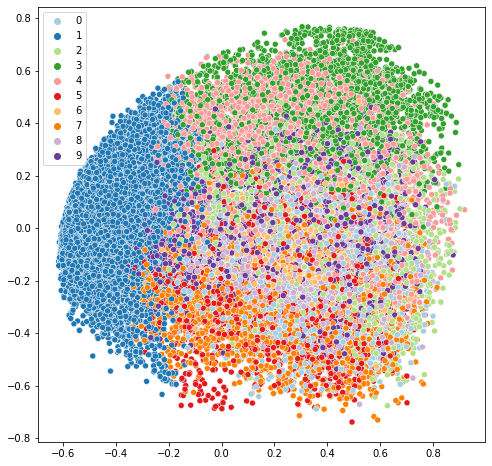

In [112]:
#plot graph
plt.figure(figsize=(8,8))
h = sns.scatterplot(reduced[:,0],reduced[:,1], hue=clusterer.labels_, palette="Paired")

PCA doesn't perform quite well for most of the topics, while only one topic is clearly defined in a separate group, while PCA fails to reduce the other tweets in a way that favors clustering of the different topics.

####UMAP

In [113]:
#UMAP for dim reduction
import umap
embeddings = umap.UMAP(n_neighbors=15, metric='cosine', random_state= 42).fit_transform(document_topic_matrix_ix)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


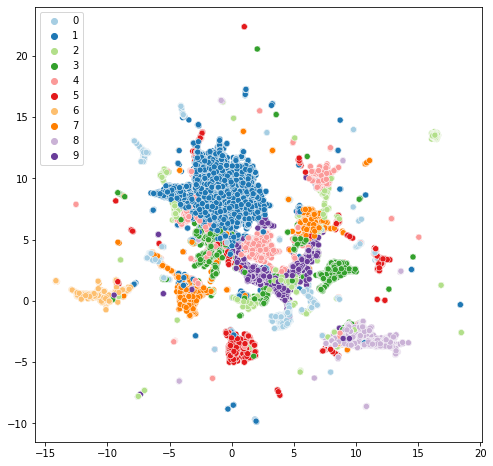

In [114]:
#plot graph
plt.figure(figsize=(8,8))
g = sns.scatterplot(*embeddings.T, hue=clusterer.labels_, palette="Paired")

On the other hand, UMAP has performed quite well in reducing dimensionality in a way where the datapoints form different clusters.
KMeans managed to match the clusters with almost half of the topics previously found, showing separate groups. Only few topics seem to have failed a proper grouping, either by being furthered grouped into two different sub-clusters or by not having clustered at all.

In [115]:
#alternatively
#hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
clusterer1 = AgglomerativeClustering(n_clusters=10).fit(document_topic_matrix_ix)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


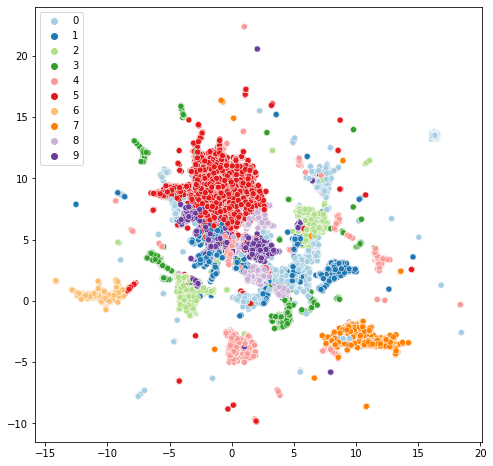

In [116]:
#plot graph, hierarchical clustering and UMAP
plt.figure(figsize=(8,8))
f = sns.scatterplot(*embeddings.T, hue=clusterer1.labels_, palette="Paired")

Hierachhical clustering performs quite similarly to KMeans in clustering the different datapoints together in a way that represents the different topics previously found with LSI.
Apart from a couple of topics, all the others are more or less clearly grouped.

Therefore, the best results in terms of traditional UML methods, were those provided by UMAP for dimensionality reduction, and by really taking a closer look, it seems like KMeans performed slightly better in terms of finding the different clusters.

###LDA Model Corpus
This section will carry out the same steps that were followed for the LSI corpus swapping it for the LDA one in order to compare, at the end, which of the two corpora has performed better for our dataset and potentially, gain further insights in the underlying patterns of the tweets.

####PCA

In [117]:
#LDA corpus
lda_corpus = twitter_lda_model[train_corpus_tfidf]

In [118]:
#apply MatrixSimilarity to create document-topic (dense) matrix
document_topic_matrix_lda = MatrixSimilarity(lda_corpus)

#create document-topic matrix index
document_topic_matrix_lda_ix = document_topic_matrix_lda.index

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [119]:
#fit Kmeans to document topic matrix_lda
clusterer.fit(document_topic_matrix_lda_ix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [120]:
#PCA for dimensionality reduction
reduced_lda = PCA(n_components = 10).fit_transform(document_topic_matrix_lda_ix)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


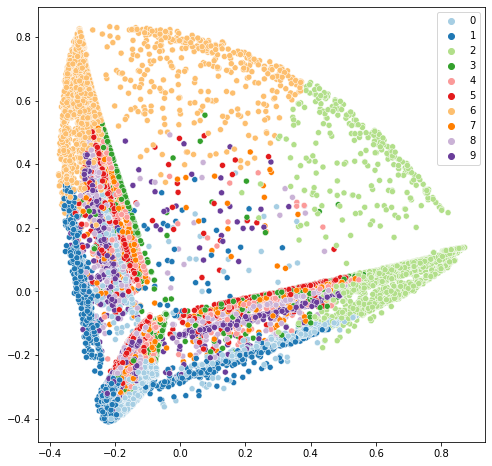

In [121]:
#plot graph
plt.figure(figsize=(8,8))
h_lda = sns.scatterplot(reduced_lda[:,0],reduced_lda[:,1], hue=clusterer.labels_, palette="Paired")

Just as for the LSI corpus, PCA does not seem to reduce dimensionality in a way that also provides a clear distinction among topics-clusters. 

####UMAP

In [122]:
#UMAP for dim reduction
embeddings_lda = umap.UMAP(n_neighbors=15, metric='cosine', random_state = 42).fit_transform(document_topic_matrix_lda_ix)

/usr/local/lib/python3.6/dist-packages/umap/rp_tree.py:778: UserWarning: Random Projection forest initialisation failed due to recursionlimit being reached. Something is a little strange with your data, and this may take longer than normal to compute.
  "Random Projection forest initialisation failed due to recursion"


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


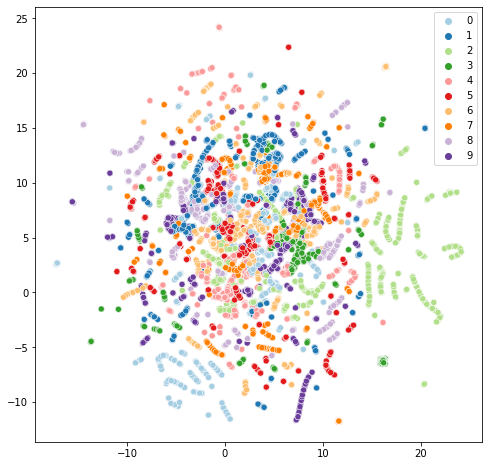

In [123]:
#plot graph
plt.figure(figsize=(8,8))
g_lda = sns.scatterplot(*embeddings_lda.T, hue=clusterer.labels_, palette="Paired")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


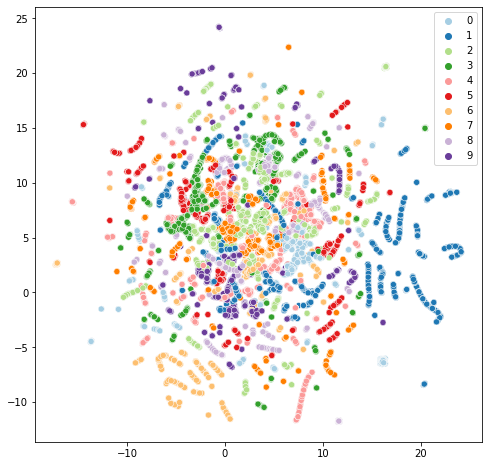

In [124]:
#alternatively
#hierarchical clustering
clusterer1 = AgglomerativeClustering(n_clusters=10).fit(document_topic_matrix_lda_ix)

#plot graph
plt.figure(figsize=(8,8))
h_lda = sns.scatterplot(*embeddings_lda.T, hue=clusterer1.labels_, palette="Paired")

UMAP also fails at reducing dimensionality in a way that groups the different datapoints in clusters as well as both KMeans and Hierarchical Clustering fail at highlighting a separation among the topic-clusters.

Therefore, we can conclude that, as it often happens in NLP topic modelling, there is no clear takeaway from the analysis carried out.
While LSI provided a clear distinction among clusters in the above plot, the same distinction was not extremely coherent from a logical standpoint. 
On the other hand, LDA generated a more coherent topic-set and a more reasonable topic distribution, but it did not succeed in attaining great separation between these clusters, as it was shown above.

## Supervised Machine Learning

In the last section of our analysis, we link the natural language processing to machine learning. Namely, we want to use the processed texts and tokens from NLP to predict whether or not a tweet is coming from a customer support agent that works for a company. This means that we are facing a **binary classification problem** as we are trying to distinguish between a target feature that can take on two possible values. 

We will train and test the different classifiers of *LogisticRegression* and the *RandomForestClassifier* to see which one performs best. To each of these different classifiers, we also apply text representations in form of BoW, tf-idf scaled, and a dimentionality reduced text representations (this time, we chose LSI). A classification report as well as the confusion matrix for each of the models will be provided.

### Logistic Regression

In [125]:
# import metrics for model evaluation
from sklearn.metrics import classification_report, confusion_matrix

In [127]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(bow_train.T, train_tweets.company_author)
model.fit(tfidf_train.T, train_tweets.company_author)

print('BoW Score: ' + str(model.score(bow_test.T, test_tweets.company_author)))
print('TFIDF Score: ' + str(model.score(tfidf_test.T, test_tweets.company_author)))

BoW Score: 0.85224
TFIDF Score: 0.89208


In [128]:
# Metrics of LogisticRegression for BoW 
print(confusion_matrix(test_tweets['company_author'], model.predict(bow_test.T)))
print(classification_report(test_tweets['company_author'], model.predict(bow_test.T)))

# Metrics of LogisticRegression for TF-IDF scaled BoW
print(confusion_matrix(test_tweets['company_author'], model.predict(tfidf_test.T)))
print(classification_report(test_tweets['company_author'], model.predict(tfidf_test.T)))

[[5436 1417]
 [ 430 5217]]
              precision    recall  f1-score   support

           0       0.93      0.79      0.85      6853
           1       0.79      0.92      0.85      5647

    accuracy                           0.85     12500
   macro avg       0.86      0.86      0.85     12500
weighted avg       0.86      0.85      0.85     12500

[[6368  485]
 [ 864 4783]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6853
           1       0.91      0.85      0.88      5647

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



If we train and test the *Logistic Regression* using our previously created BoW text representation, we can see that the accuracy is pretty good and also the precision and recall of the two potential outcomes of the target variable is fine. However, we can see that the metrics clearly improve across almost all areas when instead of the BoW we use its tf-idf scaled version. We are especially happy about the high recall score.

In the next step, we'll compare these results to the LSI reduced version applied to the *Logistic Regression*.

In [129]:
# fit on LSI representation

model.fit(lsi_train.T, train_tweets.company_author)

print('LSI Score: ' + str(model.score(lsi_test.T, test_tweets.company_author)))

LSI Score: 0.76816


In [130]:
# Metrics of LogisticRegression for BoW 
print(confusion_matrix(test_tweets['company_author'], model.predict(lsi_test.T)))
print(classification_report(test_tweets['company_author'], model.predict(lsi_test.T)))

[[6160  693]
 [2205 3442]]
              precision    recall  f1-score   support

           0       0.74      0.90      0.81      6853
           1       0.83      0.61      0.70      5647

    accuracy                           0.77     12500
   macro avg       0.78      0.75      0.76     12500
weighted avg       0.78      0.77      0.76     12500



We can see that in comparison to the Bow and tf-idf scaled version, using the LSI reduced text representation results in our model being less accurate. This goes not only for its accuracy, but also for the recall and f1 score. Especially the predictive quality for tweets from companies (where *company_author* = 1) has deteriorated.

Next, we will apply the same text representations to the RandomForestClassifier.

### RandomForestClassifier

In [131]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=10)

rf.fit(bow_train.T, train_tweets.company_author)
rf.fit(tfidf_train.T, train_tweets.company_author)

print('BoW Score: ' + str(rf.score(bow_test.T, test_tweets.company_author)))
print('TF-IDF Score: ' + str(rf.score(tfidf_test.T, test_tweets.company_author)))

BoW Score: 0.79368
TF-IDF Score: 0.87448


In [132]:
# Metrics of LogisticRegression for BoW 
print(confusion_matrix(test_tweets['company_author'], rf.predict(bow_test.T)))
print(classification_report(test_tweets['company_author'], rf.predict(bow_test.T)))
# Metrics of LogisticRegression for TF-IDF scaled BoW
print(confusion_matrix(test_tweets['company_author'], rf.predict(tfidf_test.T)))
print(classification_report(test_tweets['company_author'], rf.predict(tfidf_test.T)))

[[5713 1140]
 [1439 4208]]
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      6853
           1       0.79      0.75      0.77      5647

    accuracy                           0.79     12500
   macro avg       0.79      0.79      0.79     12500
weighted avg       0.79      0.79      0.79     12500

[[6073  780]
 [ 789 4858]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      6853
           1       0.86      0.86      0.86      5647

    accuracy                           0.87     12500
   macro avg       0.87      0.87      0.87     12500
weighted avg       0.87      0.87      0.87     12500



Looking at above classifiction reports and confusion matrices, we can see that altough similar, the *RandomForestClassifier* is not as successful in its prediction than the *Logistic Regression*. However, similar to the case using *Logistic Regression*, tf-idf scaling resulted in a significant improvement of the model.

Next, we will again have a look at how the *RandomForestClassifier* performs when it is applied to the LSI reduced text representation.

In [133]:
rf = RandomForestClassifier(random_state=10)

rf.fit(lsi_train.T, train_tweets.company_author)

print('LSI Score: ' + str(rf.score(lsi_test.T, test_tweets.company_author)))


LSI Score: 0.83056


In [134]:
# Metrics of LogisticRegression for BoW 
print(confusion_matrix(test_tweets['company_author'], rf.predict(lsi_test.T)))
print(classification_report(test_tweets['company_author'], rf.predict(lsi_test.T)))

[[6023  830]
 [1288 4359]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      6853
           1       0.84      0.77      0.80      5647

    accuracy                           0.83     12500
   macro avg       0.83      0.83      0.83     12500
weighted avg       0.83      0.83      0.83     12500



Again, similar to the case with the *Logistic Regression*, the quality of the *RandomForestClassifier* reduces in comparison to the other two text representations. However, in contrast to the case with the *Logistic Regression*, the model only loses a small bit of its predictive quality. In fact, it could be argued the the *RandomForestClassifier* is more successful using the LSI reduced version than with using the BoW text representation, which was definitely not the case for the *Logistic Regression*.